## Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. Внимание! выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.



In [ ]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/for_colab")

Mounted at /content/for_colab


In [ ]:
!unzip "/content/for_colab/My Drive/for_colab/assignment2_data.zip" -d /content/data

Archive:  /content/for_colab/My Drive/for_colab/assignment2_data.zip
  inflating: /content/data/assignment_2_test.csv  
  inflating: /content/data/assignment_2_train.csv  


In [ ]:
data = pd.read_csv("data/assignment_2_train.csv")
lb_data = pd.read_csv("data/assignment_2_test.csv")
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.nunique().sort_values()

V107                  1
V14                   2
V1                    2
M9                    2
M8                    2
                  ...  
card1              9496
V127              10259
V307              14863
TransactionDT    173460
TransactionID    180000
Length: 394, dtype: int64

Очень мало не уникальных значений . Думаю фичу "TransactionDT" удалить сразу. Тем более она мешает в задании 4

In [ ]:
x_train, x_test = train_test_split(
    data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    data["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_lb_data = (lb_data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_lb_data = lb_data["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]
x_lb_data = x_lb_data[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_lb_data.shape = {} rows, {} cols".format(*x_lb_data.shape))

x_train.shape = 125999 rows, 377 cols
x_test.shape = 54001 rows, 377 cols
x_lb_data.shape = 100001 rows, 377 cols


In [ ]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)
dlbdata = xgb.DMatrix(data=x_lb_data, label=y_lb_data)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.652319
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794601	test-auc:0.79403
[20]	train-auc:0.8344	test-auc:0.829323
[30]	train-auc:0.859773	test-auc:0.855685
[40]	train-auc:0.869723	test-auc:0.863129
[50]	train-auc:0.878079	test-auc:0.868908
[60]	train-auc:0.883288	test-auc:0.87224
[70]	train-auc:0.88567	test-auc:0.874715
[80]	train-auc:0.889096	test-auc:0.877015
[90]	train-auc:0.89214	test-auc:0.878986
[100]	train-auc:0.893794	test-auc:0.880217
[110]	train-auc:0.895468	test-auc:0.882023
[120]	train-auc:0.896807	test-auc:0.883053
[130]	train-auc:0.898087	test-auc:0.884045
[140]	train-auc:0.898303	test-auc:0.884251
[150]	train-auc:0.898303	test-auc:0.884251
Stopping. Best iteration:
[132]	train-auc:0.898303	test-auc:0.884251



In [ ]:
train_roc_auc_score = roc_auc_score(y_train, model.predict(dtrain))
test_roc_auc_score = roc_auc_score(y_test, model.predict(dtest))
lb_data_roc_auc_score = roc_auc_score(y_lb_data, model.predict(dlbdata))

In [ ]:
print('train: %.4f' % train_roc_auc_score, 'test: %.4f' % test_roc_auc_score)
print('lb_data: %.4f' % lb_data_roc_auc_score)

train: 0.8983 test: 0.8843
lb_data: 0.8606


На условном лидерборде немного хуже качество

In [ ]:
train_r2_score = r2_score(y_train, model.predict(dtrain))
test_r2_score = r2_score(y_test, model.predict(dtest))
lb_data_r2_score = r2_score(y_lb_data, model.predict(dlbdata))

In [ ]:
print('train: %.4f' % train_r2_score, 'test: %.4f' % test_r2_score)
print('lb_data: %.4f' % lb_data_r2_score)

train: 0.3685 test: 0.3450
lb_data: 0.2766


Думал переплюнул учителя, облом :)

Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.



In [ ]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), train_size=0.6, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["isFraud"], train_size=0.6, shuffle=True, random_state=1,
)

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]

x_valid, x_test = train_test_split(
    x_valid, train_size=0.6, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.6, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 377 cols
x_valid.shape = 43200 rows, 377 cols
x_test.shape = 28800 rows, 377 cols


In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]


print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 377 cols
x_valid.shape = 43200 rows, 377 cols
x_test.shape = 28800 rows, 377 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.652053	test-auc:0.653292
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.753536	test-auc:0.73885
[20]	train-auc:0.824042	test-auc:0.814604
[30]	train-auc:0.857382	test-auc:0.845321
[40]	train-auc:0.871791	test-auc:0.859833
[50]	train-auc:0.879822	test-auc:0.866307
[60]	train-auc:0.885592	test-auc:0.871634
[70]	train-auc:0.889162	test-auc:0.873939
[80]	train-auc:0.891468	test-auc:0.876364
[90]	train-auc:0.893669	test-auc:0.87769
[100]	train-auc:0.895251	test-auc:0.878906
[110]	train-auc:0.897052	test-auc:0.880055
[120]	train-auc:0.898373	test-auc:0.880545
[130]	train-auc:0.898977	test-auc:0.880556
[140]	train-auc:0.898977	test-auc:0.880556
Stopping. Best iteration:
[121]	train-auc:0.898511	test-auc:0.880638



In [ ]:
train_roc_auc_score = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score, 'test: %.4f' % test_roc_auc_score, 'valid: %.4f' % valid_roc_auc_score)
print('lb_data: %.4f' % lb_data_roc_auc_score)

train: 0.8990 test: 0.8806 valid: 0.8804
lb_data: 0.8606


Примерно схожая картина с первым заданием

Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.



In [ ]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [ ]:
np.random.seed(27)
scores_test = create_bootstrap_metrics(y_test.values, model.predict(dtest), roc_auc_score)
calculate_confidence_interval(scores_test)

(0.8658664908704963, 0.8951009865703493)

In [ ]:
np.random.seed(27)
scores_valid = create_bootstrap_metrics(y_valid.values, model.predict(dvalid), roc_auc_score)
calculate_confidence_interval(scores_valid)

(0.868879635160006, 0.8913565811868477)

Text(0.5, 0, 'sampel number')

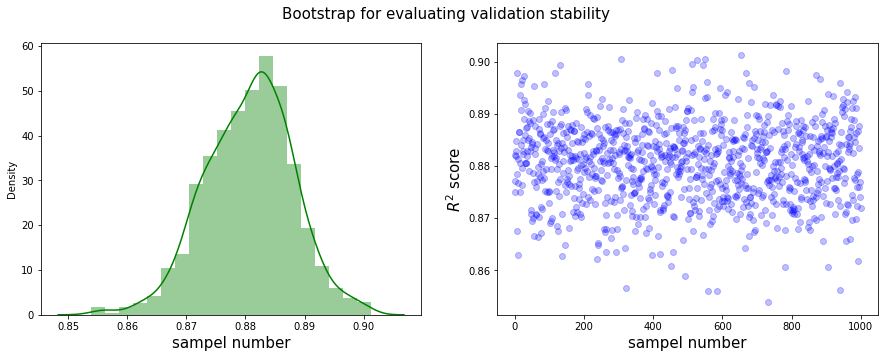

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores_test)), scores_test, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores_test, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Text(0.5, 0, 'sampel number')

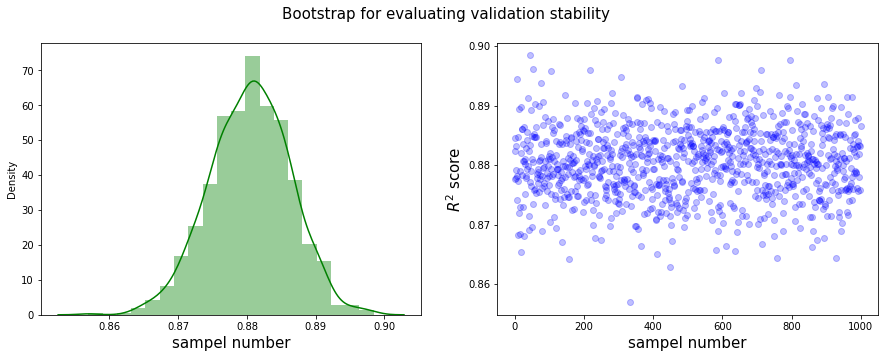

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores_valid)), scores_valid, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores_valid, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

In [ ]:
lb_data_roc_auc_score

0.8606473727945263

In [ ]:
calculate_confidence_interval(scores_test)[0] < lb_data_roc_auc_score and \
                              calculate_confidence_interval(scores_test)[1] > lb_data_roc_auc_score

False

In [ ]:
calculate_confidence_interval(scores_valid)[0] < lb_data_roc_auc_score and \
                              calculate_confidence_interval(scores_valid)[1] > lb_data_roc_auc_score

False

Качество на лидерборде оказалось за рамками доверительного интервала, значит валидация плохая

Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.



In [ ]:
x_train_adversarial_validation_f, x_test_adversarial_validation = train_test_split(
    data.drop(["TransactionID", "TransactionDT"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)

x_lb_data_adversarial_validation = x_lb_data

In [ ]:
x_train_adversarial_validation = x_train_adversarial_validation_f[numerical_features]
x_lb_data_adversarial_validation = x_lb_data_adversarial_validation[numerical_features]

print("x_train_adversarial_validation.shape = {} rows, {} cols".format(*x_train_adversarial_validation.shape))
print("x_lb_data_adversarial_validation.shape = {} rows, {} cols".format(*x_lb_data_adversarial_validation.shape))

x_train_adversarial_validation.shape = 125999 rows, 377 cols
x_lb_data_adversarial_validation.shape = 100001 rows, 377 cols


In [ ]:
X_adv = pd.concat([
    x_train_adversarial_validation, x_lb_data
])
y_adv = np.hstack(
    (np.ones(x_train_adversarial_validation.shape[0]), np.zeros(x_lb_data.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [ ]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print('CV-score: %.4f' % np.mean(cv))

CV-score: 0.8678
CPU times: user 6min 7s, sys: 998 ms, total: 6min 8s
Wall time: 3min 9s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

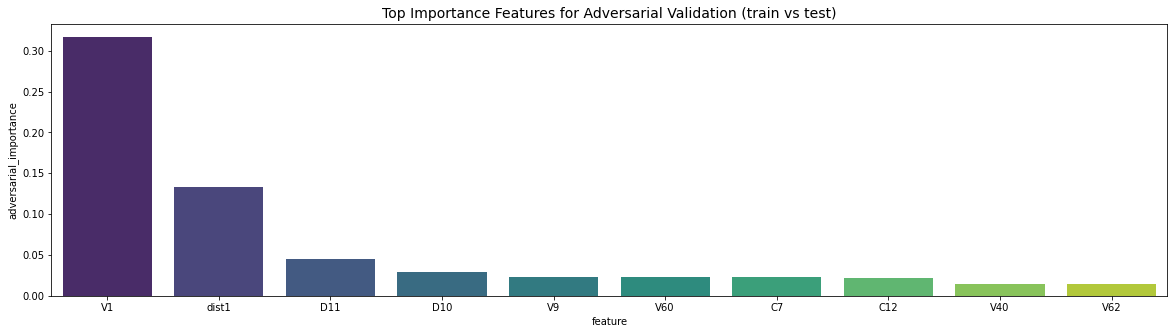

In [ ]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [ ]:
y_pred_adv = model.predict_proba(X_adv[numerical_features])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print("%.4f"% score)

0.8692


Очень близко к единице, мало похожи

In [ ]:
y_pred = model.predict_proba(x_train_adversarial_validation[numerical_features])
y_pred

array([[0.2649269 , 0.7350731 ],
       [0.1746521 , 0.8253479 ],
       [0.23076284, 0.76923716],
       ...,
       [0.1746521 , 0.8253479 ],
       [0.26829803, 0.73170197],
       [0.4382609 , 0.5617391 ]], dtype=float32)

In [ ]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]      137
(0.1, 0.2]       76
(0.2, 0.3]       93
(0.3, 0.4]       89
(0.4, 0.5]    11210
(0.5, 0.6]    15218
(0.6, 0.7]    21001
(0.7, 0.8]    31928
(0.8, 0.9]    39714
(0.9, 1.0]     6533
dtype: int64

Лучшее совпадение в девятом квантиле - 39714

In [ ]:
len(y_pred[:, 1][(y_pred[:, 1]>0.8) & (y_pred[:, 1]<0.9)])

39714

In [ ]:
x_train_adversarial_validation_f.shape

(125999, 393)

In [ ]:
# nf = numerical_features.copy()
# nf.insert(0, 'isFraud')

In [ ]:
x_train_adversarial_validation_f['av'] = np.nan
x_train_adversarial_validation_f['av'] = y_pred[:, 1]

x_train_adversarial_validation_f = x_train_adversarial_validation_f.loc[x_train_adversarial_validation_f.loc[:, 'av'] >= 0.7, :]
x_train_adversarial_validation_f = x_train_adversarial_validation_f.loc[x_train_adversarial_validation_f.loc[:, 'av'] <= 0.8, :]
y_train_adversarial_validation = x_train_adversarial_validation_f['isFraud']
x_train_adversarial_validation_f.drop(['isFraud'], axis='columns', inplace=True)
x_train_adversarial_validation_f.drop(['av'], axis='columns', inplace=True)
x_train_adversarial_validation_f = x_train_adversarial_validation_f[numerical_features]
x_train_adversarial_validation_f.shape

(31928, 377)

In [ ]:
dtrain = xgb.DMatrix(data=x_train_adversarial_validation_f, label=y_train_adversarial_validation)
dlbdata = xgb.DMatrix(data=x_lb_data_adversarial_validation, label=y_lb_data)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dlbdata, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.661567	test-auc:0.60427
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.735946	test-auc:0.673874
[20]	train-auc:0.831619	test-auc:0.791381
[30]	train-auc:0.840442	test-auc:0.811115
[40]	train-auc:0.862789	test-auc:0.84402
[50]	train-auc:0.874765	test-auc:0.849425
[60]	train-auc:0.881985	test-auc:0.850743
[70]	train-auc:0.885971	test-auc:0.851847
[80]	train-auc:0.887562	test-auc:0.852342
[90]	train-auc:0.887562	test-auc:0.852342
[100]	train-auc:0.887701	test-auc:0.852185
Stopping. Best iteration:
[75]	train-auc:0.887104	test-auc:0.852754



In [ ]:
predict = model.predict(dlbdata)
print(f'leader_board: {round(roc_auc_score(y_lb_data, predict), 4)}')

leader_board: 0.8522


Может я что-то не так сделал, но качество лучше не стало

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.



In [ ]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBRegressor(random_state=27)


cv = cross_val_score(
    estimator=model,
    X=data[numerical_features],
    y=data["isFraud"],
    scoring="roc_auc",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

[21:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV-results: 0.8655 +/- 0.011
CPU times: user 9min 13s, sys: 954 ms, total: 9min 13s
Wall time: 9min 14s


In [ ]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):

    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [ ]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data[numerical_features], data["isFraud"], model, metric=roc_auc_score, cv_strategy=cv_strategy
)

[21:13:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8825, valid-score = 0.8499
[21:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8775, valid-score = 0.875
[21:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8776, valid-score = 0.8802
[21:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8775, valid-score = 0.866
[21:20:59] WARNING: /workspace/src/objective/regression_obj.cu

Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.



Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).